In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [12]:
import joblib
import sklearn
import streamlit as st
import scipy

In [13]:
def make_features(df):
    """
    Aggregate horse-level features from historical races.
    Column names are consistent with model training schema.
    """
    df = df.sort_values(['Horse', 'RaceDate'])
    arima_date = pd.Timestamp('2013-12-22')

    features = (
        df.groupby('Horse')
        .apply(lambda g: pd.Series({
            'AvgPlacement_Last3': g['Finish'].rolling(3, min_periods=1).mean().iloc[-1],  # recent placement form
            'Speed_kph': g['Speed_kph'].mean(),
            'PosChange': g['PosChange'].mean(),
            'FinalCornerPos': g['FinalCornerPos'].mean(),
            'DaysSinceLastRace': (arima_date - g['RaceDate'].max()).days,
        }))
        .reset_index()
    )

    # Add race context for Arima Kinen 2013
    features['Distance'] = 2500
    features['RaceGrade_numeric'] = 3
    features['Course'] = 'NAK'
    features['Track'] = 'Turf'
    features['Runners'] = 16

    print(f"✅ Created {len(features)} feature rows (one per horse).")
    return features

In [14]:
def build_pipeline(numeric_cols, categorical_cols):
    """Creates preprocessing + model pipeline for classification."""
    numeric_transformer = SimpleImputer(strategy='median')
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    model = RandomForestClassifier(
        n_estimators=300,
        max_depth=8,
        random_state=42,
        n_jobs=-1
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    return pipeline


In [15]:
def train_model(df, feature_cols, target_col='Win'):
    """Trains the model using the provided dataset."""
    X = df[feature_cols]
    y = df[target_col]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Separate numeric and categorical columns
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = list(set(feature_cols) - set(numeric_cols))

    pipeline = build_pipeline(numeric_cols, categorical_cols)

    print("🚀 Training model...")
    pipeline.fit(X_train, y_train)

    print("✅ Model training complete.")

    # Evaluate
    y_pred = pipeline.predict(X_val)
    y_prob = pipeline.predict_proba(X_val)[:, 1]

    print("\n📊 Validation Results:")
    print("Accuracy:", round(accuracy_score(y_val, y_pred), 4))
    print("ROC-AUC:", round(roc_auc_score(y_val, y_prob), 4))
    print("\nClassification Report:\n", classification_report(y_val, y_pred))

    return pipeline


In [16]:
def predict_race(model, race_df, feature_cols):
    """Predict win probabilities for each horse in a race."""
    X_race = race_df[feature_cols]
    race_df['Win_Prob'] = model.predict_proba(X_race)[:, 1]
    race_df['Win_Prob_Normalized'] = race_df['Win_Prob'] / race_df['Win_Prob'].sum()

    leaderboard = race_df[['Horse', 'Win_Prob', 'Win_Prob_Normalized']].sort_values(
        'Win_Prob', ascending=False
    ).reset_index(drop=True)

    print("\n🏇 Predicted Win Probabilities:")
    print(leaderboard)
    return leaderboard

In [17]:
def plot_feature_importance(model):
    """Plot feature importances from RandomForest."""
    rf = model.named_steps['classifier']
    preprocessor = model.named_steps['preprocessor']

    cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out()
    num_features = preprocessor.transformers_[0][2]
    all_features = np.concatenate([num_features, cat_features])

    importances = rf.feature_importances_
    imp_df = pd.DataFrame({'Feature': all_features, 'Importance': importances}).sort_values('Importance', ascending=False)

    plt.figure(figsize=(8, 5))
    plt.barh(imp_df['Feature'], imp_df['Importance'])
    plt.gca().invert_yaxis()
    plt.title('Feature Importance – Race Win Prediction Model')
    plt.show()


In [18]:
def run_pipeline(df):
    # Step 1: Create per-horse features
    features = make_features(df)

    # Step 2: Define features used for training and prediction
    feature_cols = [
        'Speed_kph', 'PosChange', 'FinalCornerPos', 'Runners',    
        'AvgPlacement_Last3', 'DaysSinceLastRace',  'Distance',
        'RaceGrade_numeric',  'Course', 'Track', 
    ]

    # Step 3: Train on all historical races
    model = train_model(df, feature_cols)

    # Step 4: Predict on Arima Kinen 2013 horses
    leaderboard = predict_race(model, features, feature_cols)

    # Step 5: Plot feature importance
    plot_feature_importance(model)

    return leaderboard, model

In [21]:
df = pd.read_excel(r"C:\Users\User\Documents\horse-racing-arima-kinen-2013\data\processed\cleaned.xlsx")

C:\Users\User\AppData\Local\Temp\ipykernel_20940\2987579811.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


✅ Created 16 feature rows (one per horse).
🚀 Training model...
✅ Model training complete.

📊 Validation Results:
Accuracy: 0.6721
ROC-AUC: 0.584

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.95      0.80        42
           1       0.33      0.05      0.09        19

    accuracy                           0.67        61
   macro avg       0.51      0.50      0.45        61
weighted avg       0.58      0.67      0.58        61


🏇 Predicted Win Probabilities:
               Horse  Win_Prob  Win_Prob_Normalized
0            Orfevre  0.356330             0.160933
1          Gold Ship  0.209051             0.094416
2      Win Variation  0.193287             0.087296
3       Admire Rakti  0.161534             0.072955
4     Curren Mirotic  0.155217             0.070102
5         Lovely Day  0.142941             0.064558
6        Verde Green  0.139492             0.063000
7      Danon Ballade  0.123181             0.055633
8  

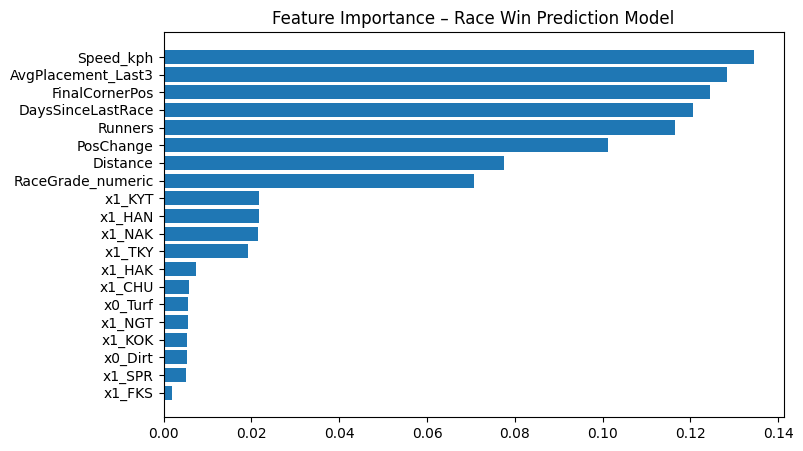

In [22]:
leaderboard, model = run_pipeline(df)

In [23]:
import cloudpickle

with open(r"C:\Users\User\Documents\horse-racing-arima-kinen-2013\models\arima_model.pkl", "wb") as f:
    cloudpickle.dump(model, f)

print("✅ Model saved (using cloudpickle) as arima_model.pkl")


✅ Model saved (using cloudpickle) as arima_model.pkl


In [24]:
features = make_features(df)
features.to_csv(r"C:\Users\User\Documents\horse-racing-arima-kinen-2013\data\processed\arima_kinen_features.csv", index=False)
print("✅ Features saved as arima_kinen_features.csv")

✅ Created 16 feature rows (one per horse).
✅ Features saved as arima_kinen_features.csv


C:\Users\User\AppData\Local\Temp\ipykernel_20940\2987579811.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [25]:
leaderboard.to_csv(r"C:\Users\User\Documents\horse-racing-arima-kinen-2013\data\processed\arima_kinen_predictions.csv", index=False)
print("✅ Leaderboard saved as arima_kinen_predictions.csv")

✅ Leaderboard saved as arima_kinen_predictions.csv
